<a href="https://colab.research.google.com/github/eftekhari-mhs/population-protocols/blob/main/dynamic_counting/dynamic_counting_sand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A dynamic size counting protocol


In this notebook, we will focus on the dynamic size counting protocol of [this](https://arxiv.org/abs/2202.12864) paper. For a better understating of this notebook, we suggest you start by reading the paper.

The Java simulator of the protocol is also available on [Github](https://github.com/eftekhari-mhs/population-protocols/blob/main/dynamic_counting/). The simulator goes through 3 phases:
1) normal phase: happens during a normal computation of the protocol, when all the metrics that the agents store are proportional.
2) waiting phase: whan an agent realizes some discrepency between 2 or more of their fields, they move on to the waiting phase so that every agent catches the same discrepency.
3) updating phase: every agent generates a new geometric random variable and propagates the maximum by epidemic. Waiting phase is long enough so that with high pobability when an agent goes to the updating phase, the rest of the popuation are either in updating or waiting. hence there is no agent in the normal phase from the last round of computation with an old value of geometric random variable. Note that, throughout the notebook $n$ is the population size. 

The java simulator stores the snapshot in a JSON formatted file. For more information about the JSON representation of the agents read the [readme](https://github.com/eftekhari-mhs/population-protocols/blob/main/dynamic_counting/README.md) file. 

**To use this notebook, click on 'Runtime' and select 'Run all'**.

# Code for fetching data and creating plots

In [1]:
#@title Technical details: Loading JSON
import json
from types import SimpleNamespace
import io
import pandas as pd
import numpy as np
from numpy.random import randint

from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt

from collections import defaultdict 

import requests

def load_file(description, flag=True, compressed_flag = False):
  if compressed_flag:
    url = 'https://raw.githubusercontent.com/eftekhari-mhs/scratch/main/compressed/dynamic_counting'
  else:
    url = 'https://raw.githubusercontent.com/eftekhari-mhs/population-protocols/main/dynamic_counting/data/dynamic_counting'
  filename = url+description+".json"  
  # print(filename)
  if flag:
    req = requests.get(filename)
    req = req.text
    # print(req)
    data = json.loads(req)
    # print(data)
  else:
    u = 'https://raw.githubusercontent.com/eftekhari-mhs/population-protocols/main/dynamic_counting/data/dynamic_'
    if compressed_flag:
      u = 'https://raw.githubusercontent.com/eftekhari-mhs/scratch/main/compressed/dynamic_'
    filename = u+description+".txt"  
    req=requests.get(filename).content
    data=pd.read_csv(io.StringIO(req.decode('utf-8')), delimiter=";|,|\[|\]",
                                      names=None, 
                                      header=None, 
                                      engine="python")


  return data

In [2]:
#@title Technical details: State Abtraction


from dataclasses import dataclass
from typing import Optional
import matplotlib as plt

from enum import Enum
class Phase(Enum):
  normal = 'normal'
  waiting = 'waiting'
  updating = 'updating'
   

@dataclass(frozen=True, eq= True)
class State:
  group: int
  grv: int
  fmv: int  
  phase: Phase
  est: int  

  def __hash__(self):
      return hash((self.group, self.grv))

In [3]:
#@title Technical details: Building dataframe for each field of an agent
#
#
#@markdown This section contains the functions that we use to retrieve data from JSON files. We make 
#@markdown a dataframe for each field of an agent to make the access easier. 
#
#@markdown There are two separate simulation results available in this notebook. 
#@markdown There are two different simulation results available in this notebook. One with a population size of 400000 in the presence of a dynamic adversary that shrinks the population down to 500. The shrinking happens in the middle of the simulation.
#@markdown The other with a population size of 10000 in the presence of a self-stabilizing adversary who starts the population in a uniformly random initial configuration.
#
#@markdown **To reveal the hidden code double click on this section.**
#

import math

group_key = "group"
rg_key = "grv"
fmv_key = "fmv"
est_key = "estimate"
phase_key = "phase"



original_size = "400000" #@param ["10000", "400000"] 
_N = int(original_size)
_LOG = round(math.log(_N)/math.log(2))
size_change = "dec" #@param ["dec"] 
array_mode = "regular" #@param ["regular"]

file_description = "_{}_{}".format(size_change,original_size)

print(f"n: {_N}; log(n): {_LOG}")     

data = load_file(file_description, compressed_flag= (array_mode=="compressed"))
# print(data)

#define columns for each dataframe based on possible values
def init_dataframe(field_name):  
  if field_name == rg_key:
    df = pd.DataFrame(columns=list(range(0, 21))) # should change based on the case  
  elif field_name == phase_key:
    df = pd.DataFrame(columns=[p for p in Phase])
  elif field_name == group_key:
    df = pd.DataFrame(columns=list(range(0, 40))) # should change based on the case  
  elif field_name == est_key:
    df = pd.DataFrame(columns=list(range(0, 21))) # should change based on the case  
  elif field_name == fmv_key:
      if array_mode=="compressed":
        df = pd.DataFrame(columns=list(range(0, 8)))
      else:
        df = pd.DataFrame(columns=list(range(0, 40)))
  else:
    print("unexpected value")
    df = pd.DataFrame()
  return df

def build_dict(field_name, all_states):
  new_row = defaultdict(int) 
  for state, count in all_states.items(): # Iterates through the pairs of state and count
    if field_name == rg_key:
      new_row[state.grv]+=count
    if field_name == phase_key:
      new_row[state.phase]+=count
    if field_name == group_key:
      new_row[state.group]+=count
    if field_name == fmv_key:
      new_row[state.fmv]+=count
    if field_name == est_key:
      new_row[state.est]+=count        
  return new_row


def build_dataframe(field_name):   
  t = 0 
  df = init_dataframe(field_name)
  for tikz,statesList in data["interactions"].items():     
    all_states = defaultdict(lambda: 0) #dict()    
    for state, count in statesList:
      grv = state[rg_key]            
      group = state[group_key]
      fmv = state[fmv_key]
      est = state[est_key]
      phase = Phase(state[phase_key])
      
      result = State(grv = grv, phase = phase, group = group, fmv = fmv, est = est)
      all_states[result] += count      
    
    df.loc[t] = build_dict(field_name, all_states)
    t+=1
  df = df.fillna(0)
  
  return df

n: 400000; log(n): 19


In [4]:
#@title Technical details: Plotting functions
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

def state_bar_plot(data, time, l = 40, yscale = "linear"):
  # print(data)
  dist = [data[i][time] for i in range(1, l)]
  plt.figure(figsize=(12,6))
  plt.bar(range(1, l),dist)
  # plt.ylim(ymax = 3500, ymin = 1)
  plt.title(f"Time step {time}, n = {original_size}")
  
  plt.yscale(yscale)  
  plt.show()

In the following code block, we will use the ``build_datafram(fieldname)`` function on ``fmv_key`` to generate a dataframe that shows the changes of fmv (first missing value) in the agents over the course of a simulation. 
``fmv`` represents the index of the first group with signal = 0. 

Each element in this dataframe represents the count of specific agents in the whole popualtion. For example, element(i, j) shows how many agents after $i$ interactions have their phase field equal to $j$. 



In [5]:
#@title Initialize one dataframe as example
max_yaxis = _N * (1.1) # for all plots

#load the fmv data frames
df_fmv = build_dataframe(fmv_key)
df_fmv

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,400000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,54326,41038,194100,94008,14836,1562,114,16,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7378,7103,70267,170469,114106,26375,3780,443,67,12,...,0,0,0,0,0,0,0,0,0,0
3,1039,876,11575,58667,158416,128745,33806,5718,945,197,...,0,0,0,0,0,0,0,0,0,0
4,135,104,1578,9607,49154,150575,137288,41468,8246,1671,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We could use a similar code ``build_datafram(phase_key)`` to generate a dataframe that shows the changes on ``phase``. 
As mentioned earlier, the phase field could have three different values: normal, waiting, and updating. 

In [6]:
df_phase = build_dataframe(phase_key)
print(df_phase.columns)

Index([Phase.normal, Phase.waiting, Phase.updating], dtype='object')


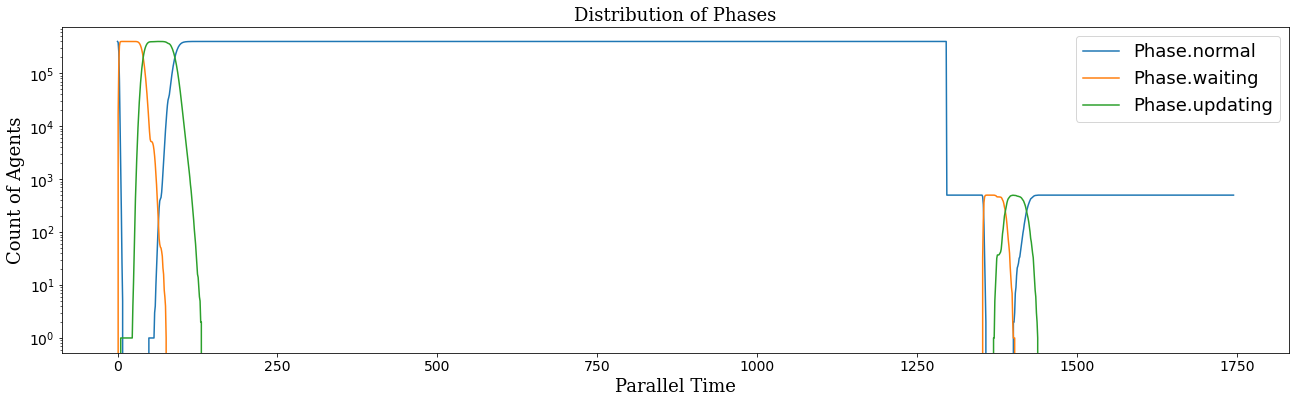

In [7]:
# colors = ['b', 'r', 'g', 'c', 'm', 'y','k']
font_large = {'family': 'serif',
          'color':  'black',
          'weight': 'normal',
          'size': 18,
          }

ax = df_phase.plot(figsize = (22,6),logy=True)

ax.set_xlabel("Parallel Time", fontdict= font_large)
ax.set_ylabel("Count of Agents", fontdict= font_large)
ax.set_title("Distribution of Phases", fontdict= font_large)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
ax.legend(prop={'size': 18})

fig = ax.get_figure()
fig.savefig('phases.svg')
fig.savefig('phases.pdf')

Finally, we generate a dataframe to store changes to agents' ``output`` value. 

In [8]:
df_output = build_dataframe(est_key)
df_output

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,400000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,400000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,400000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,400000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,400000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


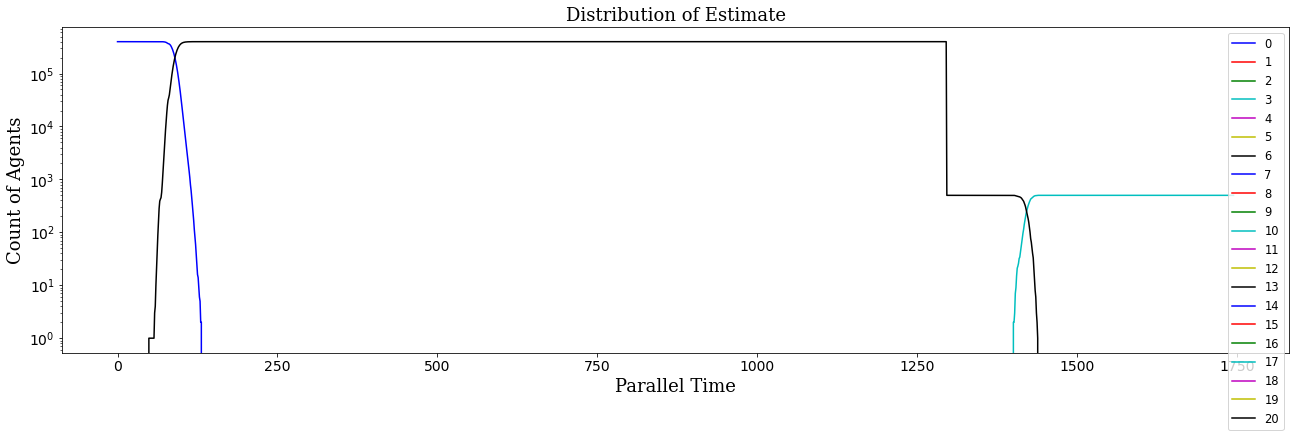

In [9]:
# b: blue
# g: green
# r: red
# c: cyan
# m: magenta
# y: yellow
# k: black
# w: white
colors = ['b', 'r', 'g', 'c', 'm', 'y','k']
ax = df_output.plot(figsize = (22,6), logy=True, color=colors)
ax.set_xlabel("Parallel Time", fontdict= font_large)
ax.set_ylabel("Count of Agents", fontdict= font_large)
ax.set_title("Distribution of Estimate", fontdict= font_large)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
ax.legend(prop={'size': 11.5})

fig = ax.get_figure()
fig.savefig('est.svg')
fig.savefig('est.pdf')

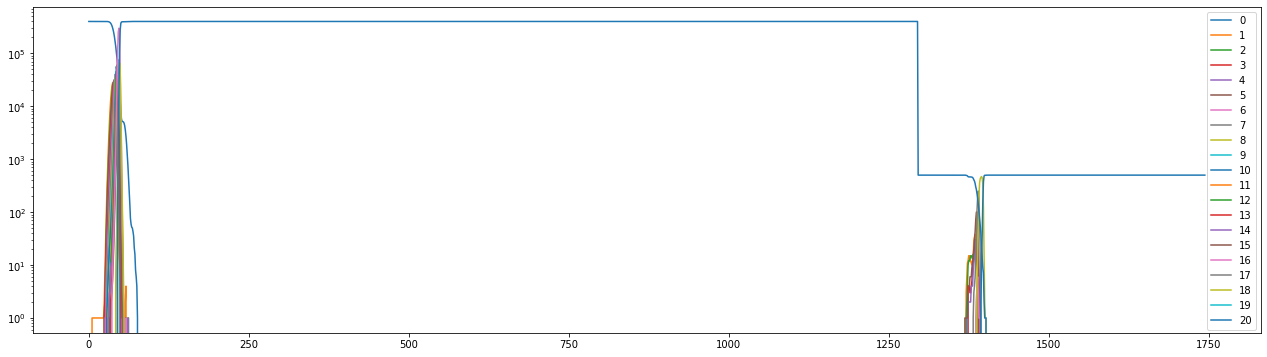

In [10]:
df_rg = build_dataframe(rg_key)
df_rg.plot(figsize = (22,6), logy=True)


## Adversarial initialization
In this section, we look at simulation result for a larger population (size = $10^6$) starting in a uniformly random distribution. All groups has about the same number of agents in them. Moreover, the group values are **disproportional** to the population size. 

In [12]:
#@markdown uncomment the following line for random initial setting on population size : 1000000
original_size = 1000000 
limit = 40


# getting the distribution of the group values across the population
df_groups = load_file("clock_inits_{}".format(original_size), False, False)


df_groups.drop(df_groups.columns[[0,limit]], axis=1, inplace=True)
df_groups.columns = range(df_groups.shape[1])

df_signals = load_file(f"clock_signals_{original_size}", False, False)

df_signals.drop(df_signals.columns[[0,limit]], axis=1, inplace=True)
df_signals.columns = range(df_signals.shape[1])


In [13]:
interact(state_bar_plot, data = fixed(df_groups), time = widgets.IntSlider(min=0, max=len(df_groups), step=1, value=0) , yscale = ["linear", "log"])

interactive(children=(IntSlider(value=0, description='time', max=1216), IntSlider(value=40, description='l', m…

<function __main__.state_bar_plot>

In [14]:
df_signals

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,0,1,4,7,9,12,15,18,21,24,...,0,0,0,0,0,0,0,0,0,NaN
1212,0,1,4,7,9,12,16,18,21,24,...,0,0,0,0,0,0,0,0,0,NaN
1213,0,1,4,6,9,13,15,18,21,24,...,0,0,0,0,0,0,0,0,0,NaN
1214,0,1,4,6,9,12,15,18,21,24,...,0,0,0,0,0,0,0,0,0,NaN


In [15]:
interact(state_bar_plot, data = fixed(df_signals), time = widgets.IntSlider(min=0, max=len(df_signals), step=1, value=0) , yscale = ["linear", "log"])

interactive(children=(IntSlider(value=0, description='time', max=1216), IntSlider(value=40, description='l', m…

<function __main__.state_bar_plot>

In [16]:
# @title save an snapshot at a give time t
def save_fig(df, t, name):
    dist = [df[i][t] for i in range(1, limit)]
    plt.figure(figsize=(12,6))
    plt.bar(range(1, limit),dist)
    plt.title(f"Time step {t}, n = {original_size}",fontsize=22)
    plt.xlabel(name, fontsize=18)
    plt.ylabel('number of agents', fontsize=18)
    plt.yscale('log')  
    # ax = df_output.plot(figsize = (22,6), logy=True, color=colors)
    # ax.set_xlabel("Parallel Time", fontdict= font_large)
    # ax.set_ylabel("Count of Agents", fontdict= font_large)
    # ax.set_title("Distribution of Estimate", fontdict= font_large)
    plt.xticks(fontsize= 18)
    plt.yticks(fontsize= 18)
    
    # plt.show()
    # export files
    plt.savefig(f"{name}_t{t}.svg")
    plt.savefig(f"{name}_t{t}.pdf")

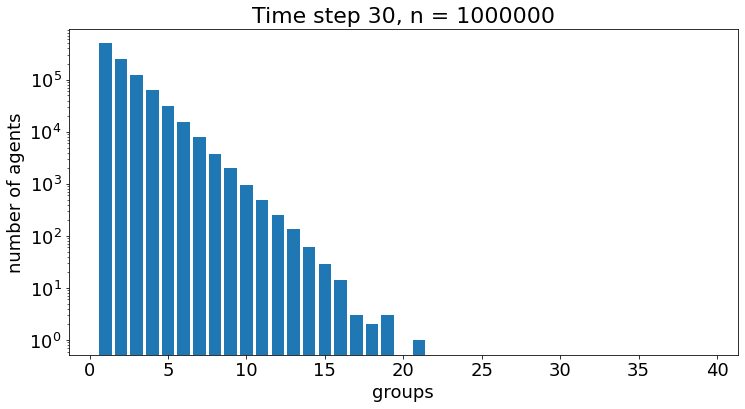

In [17]:
save_fig(df_groups, t = 30, name= 'groups')

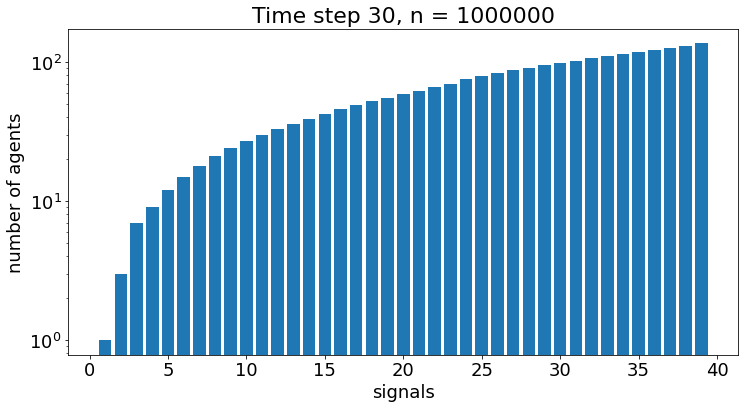

In [18]:
save_fig(df_signals, t = 30, name= 'signals')